In [ ]:
# !pip install git+https://github.com/pymc-devs/pymc3
!pip install git+git://github.com/arviz-devs/arviz.git
import arviz as az

  Cloning git://github.com/arviz-devs/arviz.git to /tmp/pip-req-build-iw0ze3fa
  Running command git clone -q git://github.com/arviz-devs/arviz.git /tmp/pip-req-build-iw0ze3fa
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 4.1MB 2.8MB/s 
     |████████████████████████████████| 317kB 49.3MB/s 
  Created wheel for arviz: filename=arviz-0.6.1-cp36-none-any.whl size=2611489 sha256=da5fedb04dcc8db1c1083f3b9e1d21a7dc6e64e2b94a2d4ad41967456ec3423a
  Stored in directory: /tmp/pip-ephem-wheel-cache-yj82qaag/wheels/a5/04/05/bff2d46cd1c6506f627675722c196cfb3f657296e6e3bfaf57
Successfully built arviz


In [ ]:
import pymc3 as pm

In [ ]:
print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.7


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import seaborn as snb
plt.style.use('seaborn-darkgrid')

# Explore Data


In [ ]:
iris = snb.load_dataset('iris')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


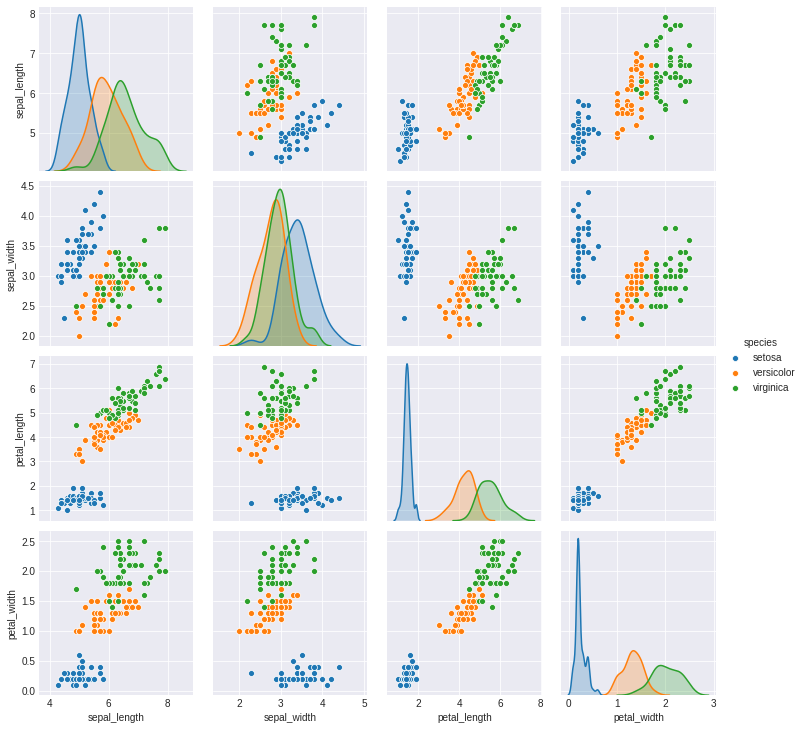

In [ ]:
# %matplotlib inline
snb.pairplot(data=iris, hue='species')
plt.show()

# Fitting

In [ ]:
for v in iris.species.unique():
    iris[v]=np.array(iris['species']==v).astype(int)
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species,setosa,versicolor,virginica
0,5.1,3.5,1.4,0.2,setosa,1,0,0
1,4.9,3.0,1.4,0.2,setosa,1,0,0
2,4.7,3.2,1.3,0.2,setosa,1,0,0
3,4.6,3.1,1.5,0.2,setosa,1,0,0
4,5.0,3.6,1.4,0.2,setosa,1,0,0


In [ ]:
# from  pymc3.distributions.discrete import Categorical as cate_dist
basic_model = pm.Model()

with basic_model:
    # Priors for unknown model parameters
    bias = pm.Normal('bias', mu=0, sigma=1, shape=3)
    sl = pm.Normal('sl', mu=0, sigma=1e2, shape=3)
    sw = pm.Normal('sw', mu=0, sigma=1e2, shape=3)
    pl = pm.Normal('pl', mu=0, sigma=1e2, shape=3)
    pw = pm.Normal('pw', mu=0, sigma=1e2, shape=3)

    # Expected value of outcome
    mu=[]
    for i in range (3):
        theta=bias[i] + sl[i]*iris.sepal_length + sw[i]*iris.sepal_width + pl[i]*iris.petal_length + pw[i]*iris.petal_width
        mu.append(pm.math.sigmoid(theta))

    # mu0=pm.Deterministic('mu0', pm.math.sigmoid(theta[0]))
    # mu1=pm.Deterministic('mu1', pm.math.sigmoid(theta[1]))
    # mu2=pm.Deterministic('mu2', pm.math.sigmoid(theta[2]))

    # Likelihood (sampling distribution) of observations
    setosa=pm.Bernoulli('setosa', mu[0], observed=iris.setosa)
    versi=pm.Bernoulli('versicolor', mu[1], observed=iris.versicolor)
    virgi=pm.Bernoulli('virginica', mu[2], observed=iris.virginica)
    # 'out',act_out, observed=ann_output, total_size=Y_train.shape[0] # IMPORTANT for minibatches

    step = pm.Metropolis()
    trace = pm.sample(step=step)

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [pw]
>Metropolis: [pl]
>Metropolis: [sw]
>Metropolis: [sl]
>Metropolis: [bias]
100%|██████████| 5500/5500 [00:09<00:00, 589.77it/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [ ]:
map_estimate = pm.find_MAP(model=basic_model, method='powell') #sampling, ....
map_estimate

/usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
  0%|          | 0/5000 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/scipy/optimize/_minimize.py:506: RuntimeWarning: Method powell does not use gradient information (jac).
  RuntimeWarning)
logp = -158.41, ||grad|| = 2.8499: 100%|██████████| 3808/3808 [00:03<00:00, 1066.36it/s]


{'bias': array([-6.68423841e-05,  1.50501540e+00, -4.73978974e-01]),
 'pl': array([-1.01607618,  1.82811183,  6.00320462]),
 'pw': array([-21.00190965,  -3.84549555,   7.36789029]),
 'sl': array([-1.53393856, -0.02307667, -3.64630478]),
 'sw': array([ 9.85505961, -1.50325109, -6.40309992])}

# Visualize

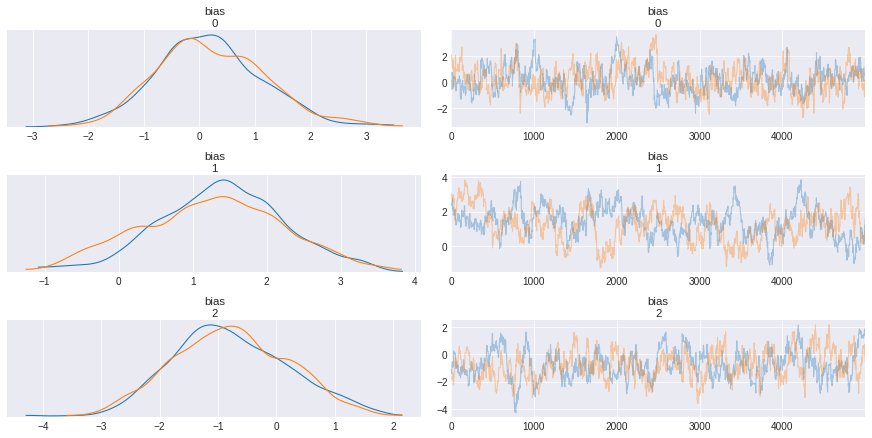

In [ ]:
az.plot_trace(trace, var_names=["bias"]);

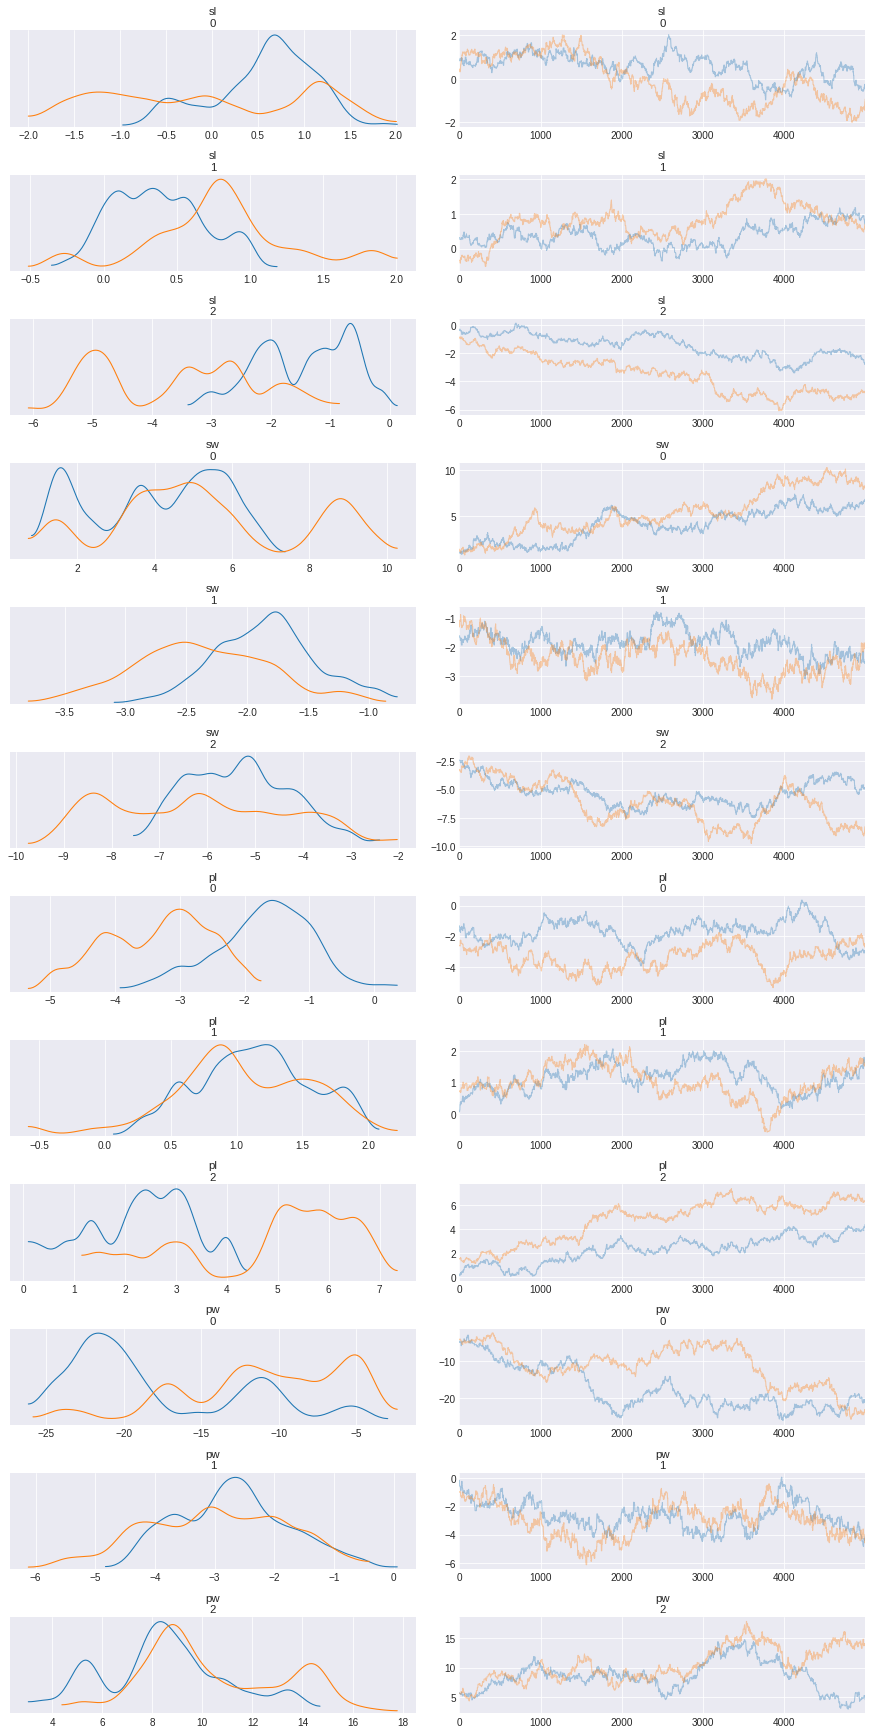

In [ ]:
az.plot_trace(trace, var_names=["sl", "sw", "pl", "pw"]);

# Get parameters trained

In [ ]:
pm.summary(trace).round(2)

/usr/local/lib/python3.6/dist-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
bias__0,0.21,0.99,0.07,-1.79,2.07,117.40,1.00
bias__1,1.33,0.92,0.08,-0.46,3.17,54.57,1.01
bias__2,-0.78,1.00,0.08,-2.62,1.23,126.39,1.00
sl__0,0.25,0.91,0.09,-1.66,1.55,5.25,1.13
sl__1,0.59,0.48,0.05,-0.38,1.55,5.34,1.22
sl__2,-2.50,1.50,0.15,-5.40,-0.39,2.19,1.66
sw__0,4.69,2.22,0.22,1.13,9.11,4.98,1.10
sw__1,-2.11,0.56,0.05,-3.13,-0.93,4.83,1.26
sw__2,-5.74,1.57,0.16,-8.78,-2.99,8.85,1.08
pl__0,-2.53,1.14,0.11,-4.98,-0.77,1.75,1.79


In [ ]:
bias = trace.get_values('bias')[-1, :]
sl = trace.get_values("sl")[-1, :]
sw = trace.get_values("sw")[-1, :]
pl = trace.get_values("pl")[-1, :]
pw = trace.get_values("pw")[-1, :]

## Predict from model

In [ ]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

mu=[]
for i in range (3):
    theta=np.array(bias[i] + sl[i]*iris.sepal_length + sw[i]*iris.sepal_width + pl[i]*iris.petal_length + pw[i]*iris.petal_width)
    mu.append(sigmoid(theta))

In [ ]:
label_set=np.array(['setosa', 'versicolor', 'virginica' ])
#sampling 3 data #0 #1 #2
# prob x in data #i
# argmax(prob x)
iris['predict'] = label_set[np.argmax(mu, axis = 0)]
iris['correct']=(iris.predict==iris.species)

In [ ]:
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species,setosa,versicolor,virginica,predict,correct
0,5.1,3.5,1.4,0.2,setosa,1,0,0,setosa,True
1,4.9,3.0,1.4,0.2,setosa,1,0,0,setosa,True
2,4.7,3.2,1.3,0.2,setosa,1,0,0,setosa,True
3,4.6,3.1,1.5,0.2,setosa,1,0,0,setosa,True
4,5.0,3.6,1.4,0.2,setosa,1,0,0,setosa,True


In [ ]:
iris[iris.correct==False]

,sepal_length,sepal_width,petal_length,petal_width,species,setosa,versicolor,virginica,predict,correct
68,6.2,2.2,4.5,1.5,versicolor,0,1,0,virginica,False
70,5.9,3.2,4.8,1.8,versicolor,0,1,0,virginica,False
83,6.0,2.7,5.1,1.6,versicolor,0,1,0,virginica,False
129,7.2,3.0,5.8,1.6,virginica,0,0,1,versicolor,False
131,7.9,3.8,6.4,2.0,virginica,0,0,1,versicolor,False
133,6.3,2.8,5.1,1.5,virginica,0,0,1,versicolor,False


## Visualize prediction

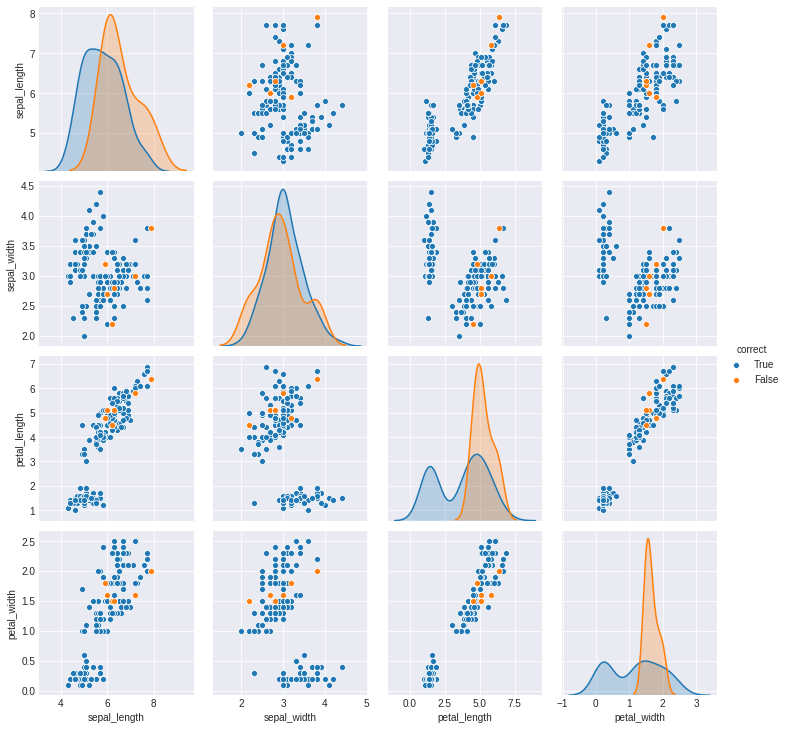

In [ ]:
snb.pairplot(data=iris[['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'correct']], hue='correct', hue_order=[True, False])
plt.show()

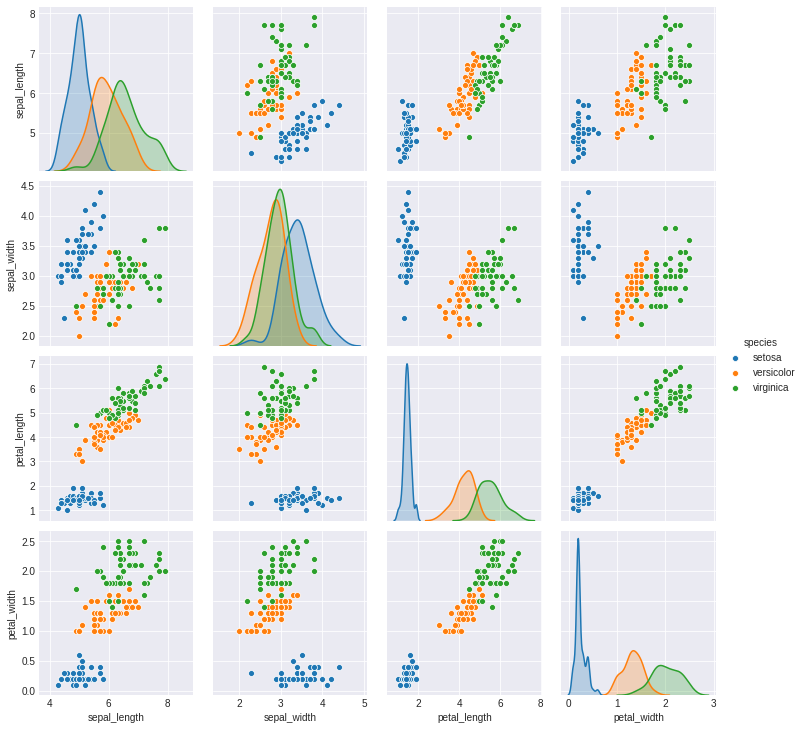

In [ ]:
snb.pairplot(data=iris[['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']], hue='species')
plt.show()

# Explain results
+ Accuracy: 0.96
+ CI of results?
+ Inference?

In [ ]:
df_trace = pm.trace_to_dataframe(trace)
df_trace.head()

,bias__0,bias__1,bias__2,sl__0,sl__1,sl__2,sw__0,sw__1,sw__2,pl__0,pl__1,pl__2,pw__0,pw__1,pw__2
0,-0.560131,2.456780,-1.134781,0.847764,0.317977,-0.373659,0.956634,-1.599893,-2.399679,-1.313492,0.065186,0.137673,-4.891170,-0.157069,5.793028
1,-0.560131,2.456780,-1.134781,0.847764,0.317977,-0.373659,0.956634,-1.599893,-2.399679,-1.313492,0.065186,0.137673,-4.891170,-0.157069,5.793028
2,-0.560131,2.456780,-1.134781,0.847764,0.317977,-0.373659,0.956634,-1.599893,-2.399679,-1.313492,0.065186,0.137673,-4.579142,-0.534484,5.594699
3,0.102868,2.456533,-1.420504,0.847764,0.317977,-0.373659,0.956634,-1.599893,-2.399679,-1.452197,0.121571,0.207383,-4.579142,-0.534484,5.594699
4,0.102868,2.456533,-1.420504,0.847764,0.317977,-0.373659,1.046258,-1.659687,-2.421216,-1.452197,0.121571,0.207383,-4.579142,-0.534484,5.594699


# Query on model

In [ ]:
print(df_trace.query("pl__0 == 0"))

Empty DataFrame
Columns: [bias__0, bias__1, bias__2, sl__0, sl__1, sl__2, sw__0, sw__1, sw__2, pl__0, pl__1, pl__2, pw__0, pw__1, pw__2]
Index: []


In [ ]:
df_trace.keys()

Index(['bias__0', 'bias__1', 'bias__2', 'sl__0', 'sl__1', 'sl__2', 'sw__0',
       'sw__1', 'sw__2', 'pl__0', 'pl__1', 'pl__2', 'pw__0', 'pw__1', 'pw__2'],
      dtype='object')